<h1 style="color: Violet; font-size:30px">Individual Project: HR Analytics</h1>


## Author: 
Linh Quach

## Date:
July 13, 2021

## Dataset
HR Analytics: Job Change of Data Scientists

# Executive Summary:
## Key Takeaways:
The following are key takeways:

- There is not one main driver for job change of Data Scientists.

- The top factors that affect job change of Data Scientists include company type, relevent experience and status of enrollment in a University.

- All models performed similarly except for KNeighbors had a lower accuracy score than the baseline

- When comparing train and validate datasets in all the models we see none of the models are overfit.

- Decision Tree model 2 is best model in terms of accuracy.

- Decision Tree model 2 is better than baseline but with more time I would continue to work with this model to improve the accuracy score

- The models I created were a Decision tree, Logistic Regression Model, KNeighbors, and Random Forest Model predicted similar accuracy scores for the training dataset. The model I chose was the Decision Tree model 2 as my best model with a 75.52% accuracy rate for predicting features of company type, relevent experience, status of University enrollment, last new job.

- The Decision Tree model 2 (75.52%) outperformed my baseline score of 75.09% thus it has some value.


## Plan

## The Issue:
- What drivers can cause job changes of Data Scientists?

## Project goals:
- Find features for Job Change of Data Scientists
- Construct a ML classification model that accurately predicts who will move to a new job

## The data science pipeline process:
- Acquire the data
- Prepare and clean data
- Explore
- Model & Evaluate
- Recommendations

# Imports

In [1]:
#Imports 
import numpy as np
import pandas as pd
from scipy import stats
from math import sqrt
from datetime import datetime

#skelearn imports
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import explained_variance_score


#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

#Stats models
# import statsmodels.api as sm
# from statsmodels.tsa.api import Holt

#Docs
import acquire
import prepare
import explore

import warnings
warnings.filterwarnings("ignore")

In [2]:
#acquiring aug_train csv
aug_train_df= acquire.get_aug_train('archive/aug_train.csv')

In [3]:
aug_train_df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
# Looking at shape
aug_train_df.shape

(19158, 14)

In [5]:
#Looking at datatypes
aug_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

<hr style="border-top: 10px groove blueviolet; margin-top: 1px; margin-bottom: 1px"></hr>

### **Acquire Takeaways**

    - Large amount of nulls to drop or fill in 
    - Choose to change some of the object datatypes to numeric datatype, decide to drop, or decide not to use in modeling
    -columns to consider encoding: relevant experience, enrolled_university, education_level, gender, company_type, and last_new_job columns to a numeric datatype.
<hr style="border-top: 10px groove blueviolet; margin-top: 1px; margin-bottom: 1px"></hr>

# Prepare

In [6]:
#using function above
prepare.report_unique_val (aug_train_df)

**enrollee_id**
Unique Values :  19158
 
**city**
Unique Values :  123
 
city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_129       3
city_111       3
city_121       3
city_140       1
city_171       1
Name: city, Length: 123, dtype: int64
**city_development_index**
Unique Values :  93
 
(0.446, 0.498]      63
(0.498, 0.548]     115
(0.548, 0.598]     547
(0.598, 0.648]    2750
(0.648, 0.698]    1081
(0.698, 0.749]     448
(0.749, 0.799]     962
(0.799, 0.849]     987
(0.849, 0.899]    2380
(0.899, 0.949]    9825
Name: city_development_index, dtype: int64
**gender**
Unique Values :  3
 
Male      13221
Female     1238
Other       191
Name: gender, dtype: int64
**relevent_experience**
Unique Values :  2
 
Has relevent experience    13792
No relevent experience      5366
Name: relevent_experience, dtype: int64
**enrolled_university**
Unique Values :  3
 
no_enrollment       13817
Full time course     3757
Part time course     1198

In [7]:
#Using function to see percentage of missing nulls in columns
prepare.miss_dup_values(aug_train_df)

Your selected dataframe has 14 columns.
There are 8 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Null Values
company_type,6140,32.0
company_size,5938,31.0
gender,4508,23.5
major_discipline,2813,14.7
education_level,460,2.4
last_new_job,423,2.2
enrolled_university,386,2.0
experience,65,0.3


In [8]:
#fill the gender column and company type nulls with other category
aug_train_df[['gender','company_type']] =aug_train_df[['gender','company_type']].fillna('Other')

In [9]:
#using unique value function to be sure Nulls were filled with other
prepare.report_unique_val (aug_train_df)

**enrollee_id**
Unique Values :  19158
 
**city**
Unique Values :  123
 
city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_129       3
city_111       3
city_121       3
city_140       1
city_171       1
Name: city, Length: 123, dtype: int64
**city_development_index**
Unique Values :  93
 
(0.446, 0.498]      63
(0.498, 0.548]     115
(0.548, 0.598]     547
(0.598, 0.648]    2750
(0.648, 0.698]    1081
(0.698, 0.749]     448
(0.749, 0.799]     962
(0.799, 0.849]     987
(0.849, 0.899]    2380
(0.899, 0.949]    9825
Name: city_development_index, dtype: int64
**gender**
Unique Values :  3
 
Male      13221
Other      4699
Female     1238
Name: gender, dtype: int64
**relevent_experience**
Unique Values :  2
 
Has relevent experience    13792
No relevent experience      5366
Name: relevent_experience, dtype: int64
**enrolled_university**
Unique Values :  3
 
no_enrollment       13817
Full time course     3757
Part time course     1198

In [10]:
#encode relevant experience
aug_train_df.relevent_experience.replace({'Has relevent experience': 1, 'No relevent experience': 0}, inplace = True)

In [11]:
#Verify relevant experience was changed 
aug_train_df.head(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,1,no_enrollment,Graduate,STEM,>20,NaN,Other,1,36,1.0
1,29725,city_40,0.776,Male,0,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,Other,0,Full time course,Graduate,STEM,5,NaN,Other,never,83,0.0
3,33241,city_115,0.789,Other,0,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,1,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,Other,1,Part time course,Graduate,STEM,11,NaN,Other,1,24,1.0
6,28806,city_160,0.920,Male,1,no_enrollment,High School,NaN,5,50-99,Funded Startup,1,24,0.0
7,402,city_46,0.762,Male,1,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0
8,27107,city_103,0.920,Male,1,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,46,1.0
9,699,city_103,0.920,Other,1,no_enrollment,Graduate,STEM,17,10000+,Pvt Ltd,>4,123,0.0


In [12]:
#encode relevant experience
aug_train_df.enrolled_university.replace({'Part time course': 2,'Full time course': 1, 'no_enrollment': 0}, inplace = True)

In [13]:
#Verify enrolled university column was changed 
aug_train_df.head(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,1,0.0,Graduate,STEM,>20,NaN,Other,1,36,1.0
1,29725,city_40,0.776,Male,0,0.0,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,Other,0,1.0,Graduate,STEM,5,NaN,Other,never,83,0.0
3,33241,city_115,0.789,Other,0,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,1,0.0,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,Other,1,2.0,Graduate,STEM,11,NaN,Other,1,24,1.0
6,28806,city_160,0.920,Male,1,0.0,High School,NaN,5,50-99,Funded Startup,1,24,0.0
7,402,city_46,0.762,Male,1,0.0,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0
8,27107,city_103,0.920,Male,1,0.0,Graduate,STEM,7,50-99,Pvt Ltd,1,46,1.0
9,699,city_103,0.920,Other,1,0.0,Graduate,STEM,17,10000+,Pvt Ltd,>4,123,0.0


In [14]:
#encode education level
aug_train_df.education_level.replace({'Phd': 4, 'Masters': 3, 'Graduate': 2, 'High School': 1, 'Primary School': 0}, inplace = True)

In [15]:
#Verify education level column was changed 
aug_train_df.head(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,1,0.0,2.0,STEM,>20,NaN,Other,1,36,1.0
1,29725,city_40,0.776,Male,0,0.0,2.0,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,Other,0,1.0,2.0,STEM,5,NaN,Other,never,83,0.0
3,33241,city_115,0.789,Other,0,NaN,2.0,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,1,0.0,3.0,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,Other,1,2.0,2.0,STEM,11,NaN,Other,1,24,1.0
6,28806,city_160,0.920,Male,1,0.0,1.0,NaN,5,50-99,Funded Startup,1,24,0.0
7,402,city_46,0.762,Male,1,0.0,2.0,STEM,13,<10,Pvt Ltd,>4,18,1.0
8,27107,city_103,0.920,Male,1,0.0,2.0,STEM,7,50-99,Pvt Ltd,1,46,1.0
9,699,city_103,0.920,Other,1,0.0,2.0,STEM,17,10000+,Pvt Ltd,>4,123,0.0


In [16]:
#encode gender 
aug_train_df.gender.replace({'Other': 2, 'Male': 1, 'Female': 0}, inplace = True)

In [17]:
#Verify gender column was changed 
aug_train_df.head(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,1,1,0.0,2.0,STEM,>20,NaN,Other,1,36,1.0
1,29725,city_40,0.776,1,0,0.0,2.0,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,2,0,1.0,2.0,STEM,5,NaN,Other,never,83,0.0
3,33241,city_115,0.789,2,0,NaN,2.0,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,1,1,0.0,3.0,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,2,1,2.0,2.0,STEM,11,NaN,Other,1,24,1.0
6,28806,city_160,0.920,1,1,0.0,1.0,NaN,5,50-99,Funded Startup,1,24,0.0
7,402,city_46,0.762,1,1,0.0,2.0,STEM,13,<10,Pvt Ltd,>4,18,1.0
8,27107,city_103,0.920,1,1,0.0,2.0,STEM,7,50-99,Pvt Ltd,1,46,1.0
9,699,city_103,0.920,2,1,0.0,2.0,STEM,17,10000+,Pvt Ltd,>4,123,0.0


In [18]:
#encode company type column 
aug_train_df.company_type.replace({'Other': 5, 'NGO': 4, 'Early Stage Startup': 3, 'Public Sector': 2, 'Funded Startup': 1, 'Pvt Ltd': 0}, inplace = True)

In [19]:
#Verify company type column was changed 
aug_train_df.head(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,1,1,0.0,2.0,STEM,>20,NaN,5,1,36,1.0
1,29725,city_40,0.776,1,0,0.0,2.0,STEM,15,50-99,0,>4,47,0.0
2,11561,city_21,0.624,2,0,1.0,2.0,STEM,5,NaN,5,never,83,0.0
3,33241,city_115,0.789,2,0,NaN,2.0,Business Degree,<1,NaN,0,never,52,1.0
4,666,city_162,0.767,1,1,0.0,3.0,STEM,>20,50-99,1,4,8,0.0
5,21651,city_176,0.764,2,1,2.0,2.0,STEM,11,NaN,5,1,24,1.0
6,28806,city_160,0.920,1,1,0.0,1.0,NaN,5,50-99,1,1,24,0.0
7,402,city_46,0.762,1,1,0.0,2.0,STEM,13,<10,0,>4,18,1.0
8,27107,city_103,0.920,1,1,0.0,2.0,STEM,7,50-99,0,1,46,1.0
9,699,city_103,0.920,2,1,0.0,2.0,STEM,17,10000+,0,>4,123,0.0


In [20]:
#encode company type column 
aug_train_df.last_new_job.replace({'>4': 5, '4': 4, '3': 3, '2': 2, '1': 1, 'never': 0}, inplace = True)

In [21]:
#Verify company type column was changed 
aug_train_df.head(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,1,1,0.0,2.0,STEM,>20,NaN,5,1.0,36,1.0
1,29725,city_40,0.776,1,0,0.0,2.0,STEM,15,50-99,0,5.0,47,0.0
2,11561,city_21,0.624,2,0,1.0,2.0,STEM,5,NaN,5,0.0,83,0.0
3,33241,city_115,0.789,2,0,NaN,2.0,Business Degree,<1,NaN,0,0.0,52,1.0
4,666,city_162,0.767,1,1,0.0,3.0,STEM,>20,50-99,1,4.0,8,0.0
5,21651,city_176,0.764,2,1,2.0,2.0,STEM,11,NaN,5,1.0,24,1.0
6,28806,city_160,0.920,1,1,0.0,1.0,NaN,5,50-99,1,1.0,24,0.0
7,402,city_46,0.762,1,1,0.0,2.0,STEM,13,<10,0,5.0,18,1.0
8,27107,city_103,0.920,1,1,0.0,2.0,STEM,7,50-99,0,1.0,46,1.0
9,699,city_103,0.920,2,1,0.0,2.0,STEM,17,10000+,0,5.0,123,0.0


In [22]:
#Looking at datatypes after column changes
aug_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  19158 non-null  int64  
 4   relevent_experience     19158 non-null  int64  
 5   enrolled_university     18772 non-null  float64
 6   education_level         18698 non-null  float64
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            19158 non-null  int64  
 11  last_new_job            18735 non-null  float64
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(5), int64(5), object(4)
mem

In [23]:
# Using the missing duplicate function to see how many missing values we have
prepare.miss_dup_values(aug_train_df)

Your selected dataframe has 14 columns.
There are 6 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Null Values
company_size,5938,31.0
major_discipline,2813,14.7
education_level,460,2.4
last_new_job,423,2.2
enrolled_university,386,2.0
experience,65,0.3


In [24]:
#Drop any rows or columns with less than 90% non-null values
aug_train_df= prepare.handle_missing_values(aug_train_df, prop_required_column = .9, prop_required_row = .9)

In [25]:
# Using the missing duplicate function to see how many missing values we have
prepare.miss_dup_values(aug_train_df)

Your selected dataframe has 12 columns.
There are 4 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Null Values
last_new_job,346,1.8
education_level,331,1.7
enrolled_university,266,1.4
experience,30,0.2


In [26]:
#Drop remaining null values
aug_train_df= aug_train_df.dropna()

In [27]:
# Using the missing duplicate function to see how many missing values we have and we see we not longer have any rows with nulls
prepare.miss_dup_values(aug_train_df)

Your selected dataframe has 12 columns.
There are 0 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Null Values


In [28]:
#Verify which columns are in df 
aug_train_df.columns.tolist()

['enrollee_id',
 'city',
 'city_development_index',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'experience',
 'company_type',
 'last_new_job',
 'training_hours',
 'target']

In [29]:
# Looking at datatypes after clean up
aug_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18014 entries, 0 to 19157
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             18014 non-null  int64  
 1   city                    18014 non-null  object 
 2   city_development_index  18014 non-null  float64
 3   gender                  18014 non-null  int64  
 4   relevent_experience     18014 non-null  int64  
 5   enrolled_university     18014 non-null  float64
 6   education_level         18014 non-null  float64
 7   experience              18014 non-null  object 
 8   company_type            18014 non-null  int64  
 9   last_new_job            18014 non-null  float64
 10  training_hours          18014 non-null  int64  
 11  target                  18014 non-null  float64
dtypes: float64(5), int64(5), object(2)
memory usage: 1.8+ MB


## Boxplots before dropping outliers

In [30]:
#Creating box_plot_list for boxplots (had to exclude objects)
box_plot_list= aug_train_df[['gender',
       'relevent_experience', 'enrolled_university', 'education_level', 'company_type', 'training_hours',
       'target' ]]

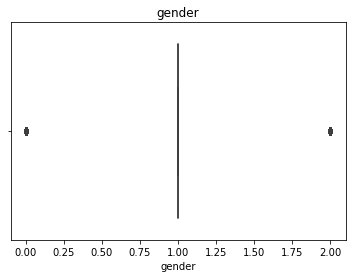

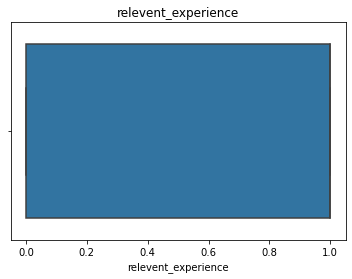

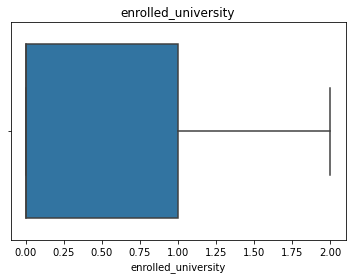

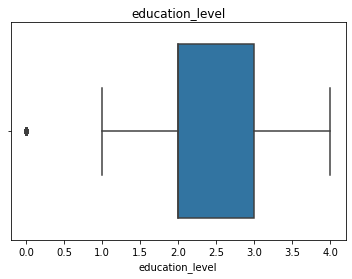

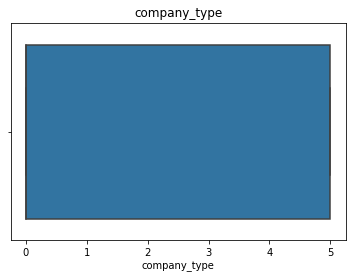

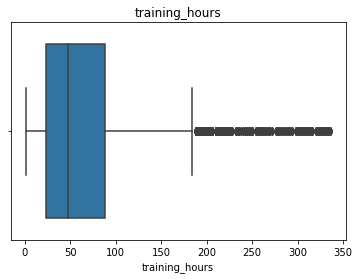

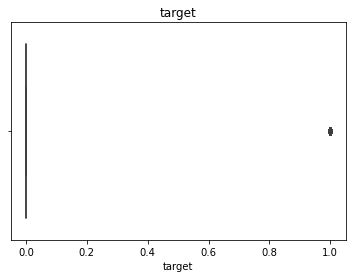

In [31]:
#Looking at boxplots before dropping outliers
for col in box_plot_list:
    sns.boxplot(aug_train_df[col])
    plt.title(col)
    plt.show()

**Dropping Outliers**

In [32]:
# drop outliers from education_level
prepare.outlier_bound_calculation(aug_train_df, 'education_level')

For education_level the lower bound is 0.5 and  upper bound is 4.5


In [33]:
#remove outliers from education_level
aug_train_df= aug_train_df[aug_train_df.education_level > 0.5]
aug_train_df= aug_train_df[aug_train_df.education_level < 4.5]

In [34]:
# drop outliers from training_hours
prepare.outlier_bound_calculation(aug_train_df, 'training_hours')

For training_hours the lower bound is -74.5 and  upper bound is 185.5


In [35]:
# remove outliers from education_level
aug_train_df= aug_train_df[aug_train_df.training_hours > -74.5]
aug_train_df= aug_train_df[aug_train_df.training_hours < 185.5]

## Boxplots after dropping outliers

In [36]:
#Creating box_plot_list for boxplots (had to exclude objects)
box_plot_list_ao= aug_train_df[['gender',
       'relevent_experience', 'enrolled_university', 'education_level', 'company_type', 'training_hours',
       'target' ]]

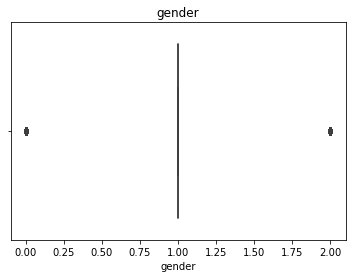

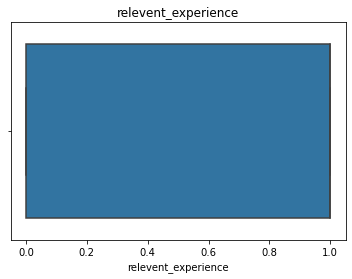

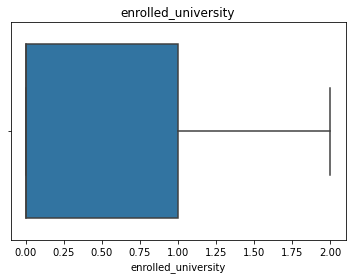

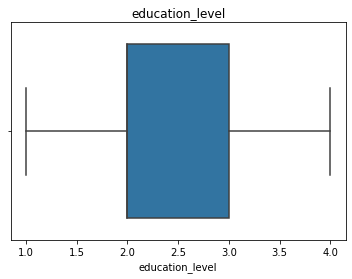

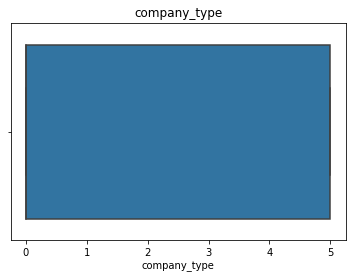

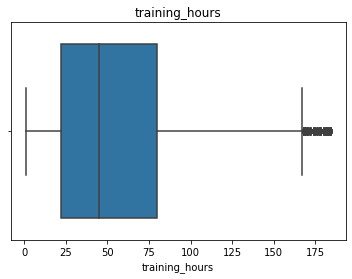

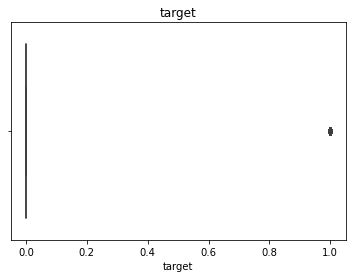

In [37]:
#Looking at boxplots after dropping outliers
for col in box_plot_list_ao:
    sns.boxplot(aug_train_df[col])
    plt.title(col)
    plt.show()

To prep this data before exploration, the following was done:


- Filled nulls in gender and company_type column with an other category
- Dropped any rows or columns with less than 90% non-null values with a function
- after intial dropping of nulls any remaining nulls were dropped
- encoded relevant experience, enrolled_university, education_level, gender, company_type, and last_new_job columns to a numeric datatype.
- Removed outliers from education level and training hours column


<hr style="border-top: 10px groove blueviolet; margin-top: 1px; margin-bottom: 1px"></hr>

### **Prepare Takeaways**

    - The cleaning process had a large amount of nulls that needed to filled in or dropped 
    - Deciding on what to fill nulls for each column was dependent on the column we were dealing with
    - For the next step of exploration, company type, status of enrollment at university, gender,  relevent experience, last new job will most likely be the most beneficial to explore
<hr style="border-top: 10px groove blueviolet; margin-top: 1px; margin-bottom: 1px"></hr>    

# Explore

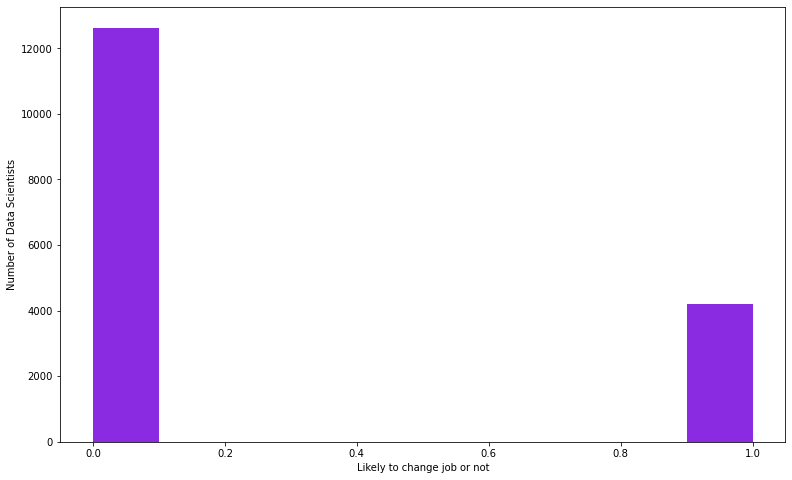

In [38]:
#Plot of Target
plt.figure(figsize=(13, 8))
aug_train_df['target'].hist(grid=False, color = 'blueviolet')
plt.xlabel("Likely to change job or not")
plt.ylabel("Number of Data Scientists")                               
plt.show()

In [39]:
#splitting data using function
train, validate, test= explore.data_split(aug_train_df)

In [40]:
#Looking at shape of each dataset
train.shape, validate.shape, test.shape

((9417, 12), (4036, 12), (3364, 12))

Text(0.5, 1.0, 'Scaled')

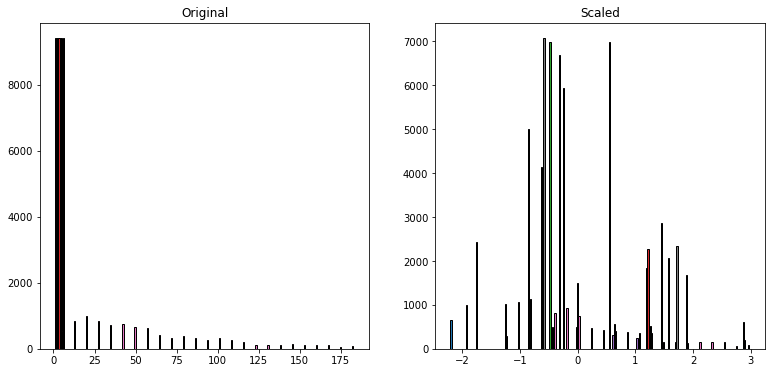

In [41]:
#Scaling data
#Creating feature list
features_scale = ['gender', 'relevent_experience', 'enrolled_university', 'education_level', 
                  'company_type', 'last_new_job', 'training_hours', 'target']

# creating standardscaler object
scaler = sklearn.preprocessing.StandardScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(train[features_scale])

train_scaled = scaler.transform(train[features_scale])
validate_scaled = scaler.transform(validate[features_scale])
test_scaled = scaler.transform(test[features_scale])

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(train[features_scale], bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(train_scaled, bins=25, ec='black')
plt.title('Scaled')

In [42]:
#Looking at correlation by target
train.corr()[['target']].sort_values(by='target', ascending=False)

,target
target,1.000000
company_type,0.235642
enrolled_university,0.111274
gender,0.039362
enrollee_id,0.037400
training_hours,-0.008274
education_level,-0.028131
last_new_job,-0.101534
relevent_experience,-0.158985
city_development_index,-0.351503


In [43]:
#Creating column list to feed into get_heatmap function
col_list= train[['company_type', 'enrolled_university', 'gender', 'training_hours', 'education_level', 'relevent_experience', 'last_new_job', 'target']]

<AxesSubplot:title={'center':'Features  Correlating with target'}>

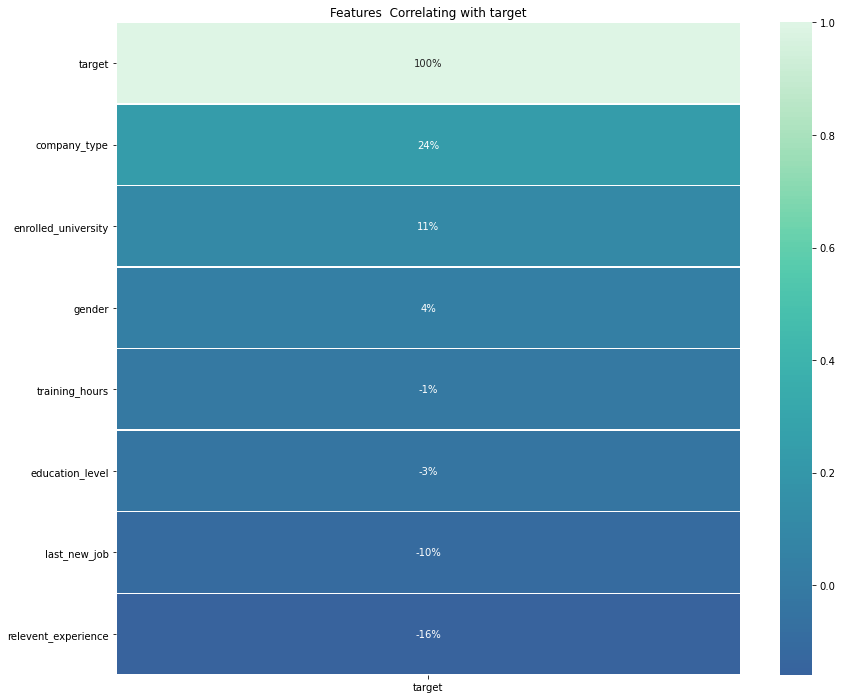

In [44]:
#visualize correlation using get_heatmap function
explore.get_heatmap(col_list, 'target',  color = 'mako')

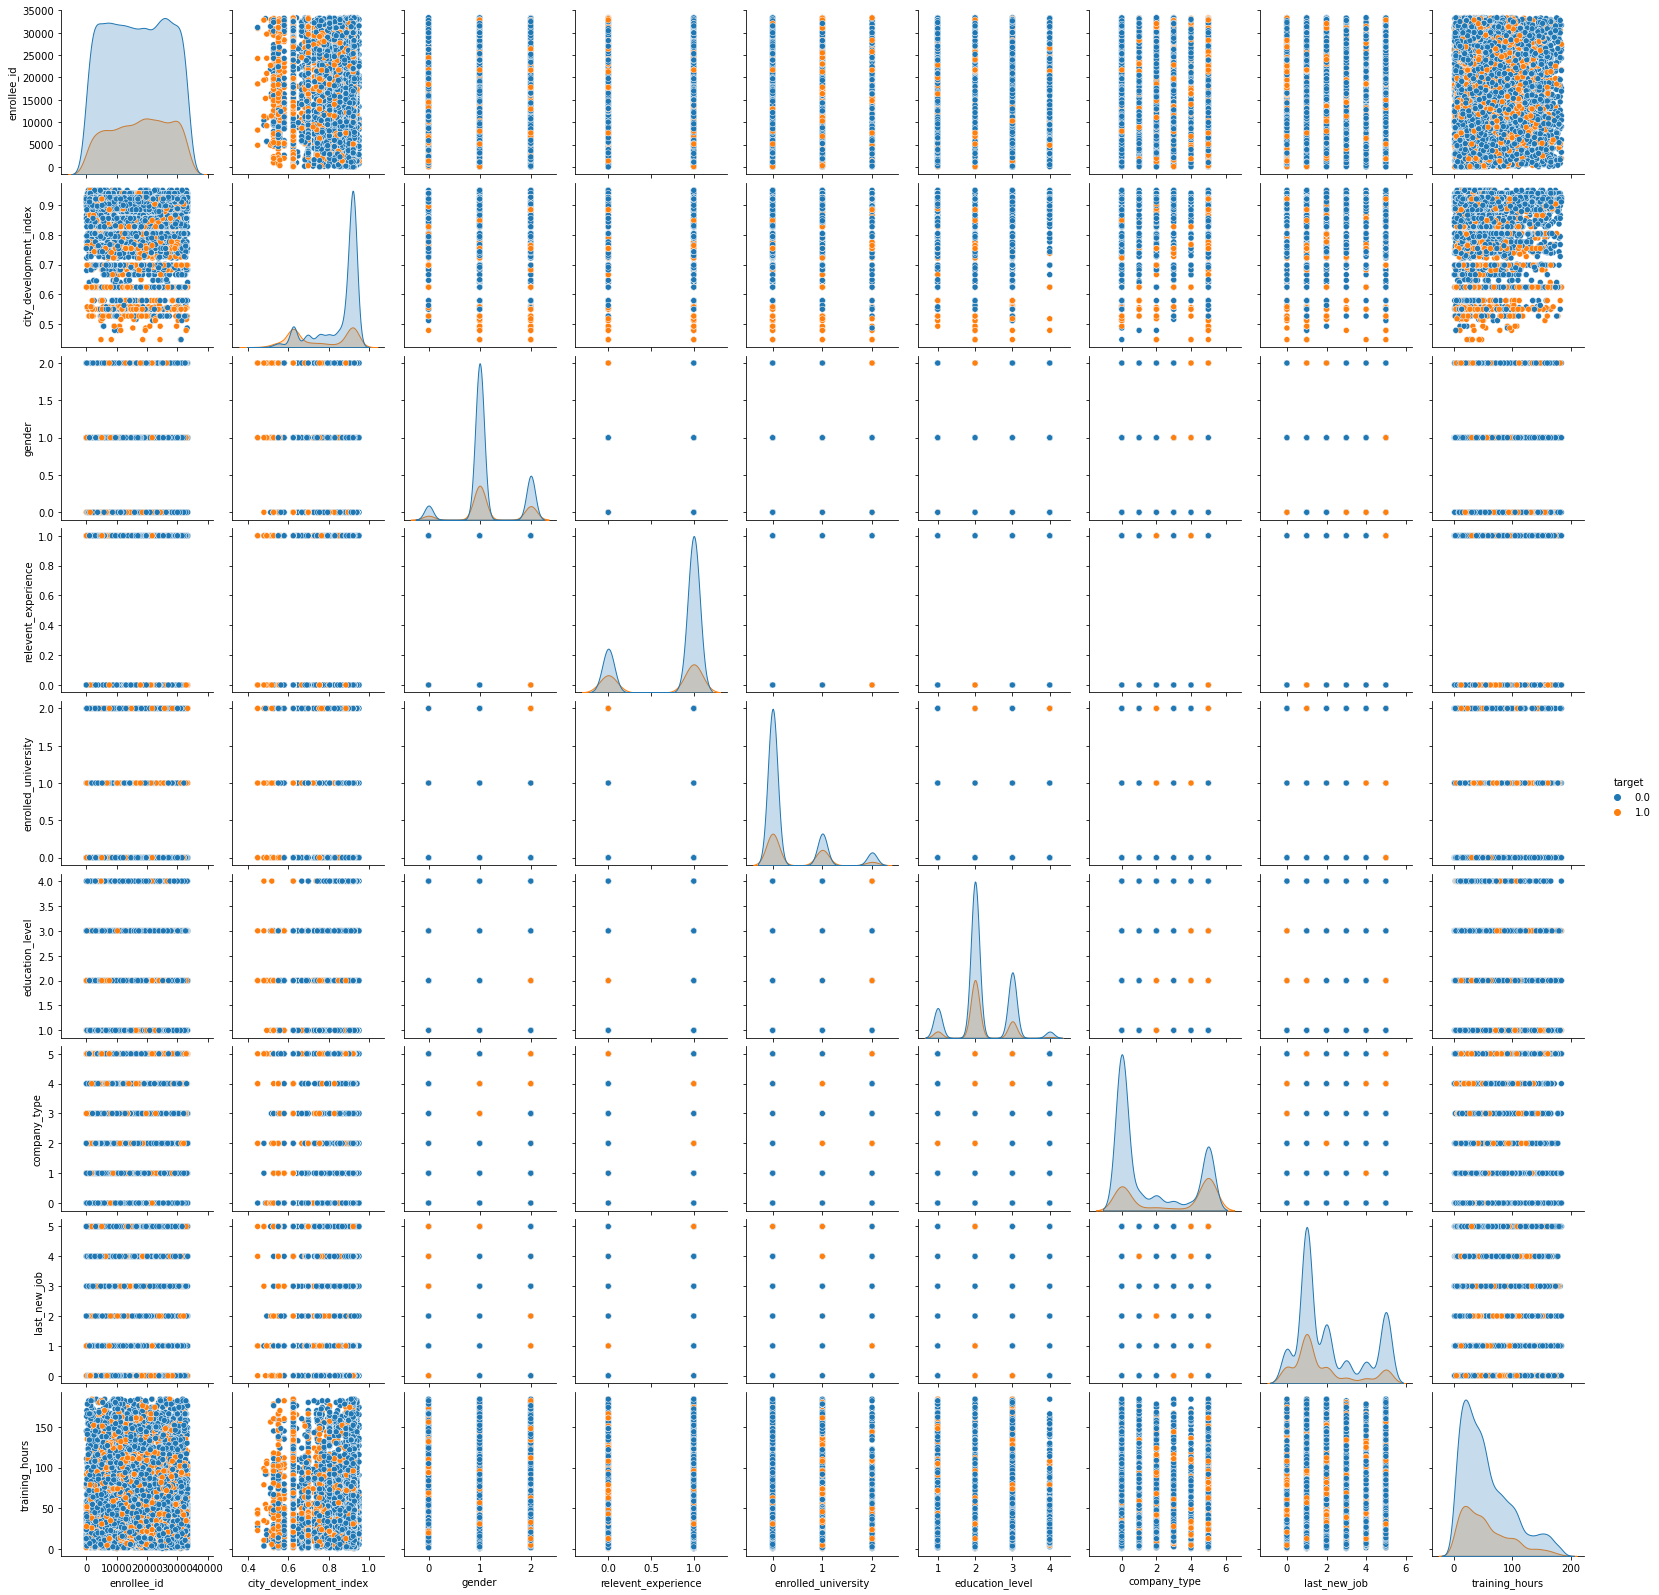

In [45]:
# Looking at overall visual features with target
sns.pairplot(data = train, hue = 'target')

## Statistics

In [46]:
# Defining alpha value
alpha = .05 

### Hypothesis 1
- $H_0$: Company type has no affect on data scientist who churn (they are independent). 
- $H_a$: Company type has an affect on data scientist who churn (they are dependent). 

In [47]:
train['company_type'].value_counts() # Looking at value counts to make sure didn't lose anything when compared to crosstab

0    4995
5    2869
1     506
2     490
3     303
4     254
Name: company_type, dtype: int64

In [48]:
#Performing chi^2 test
company_type_crosstab= pd.crosstab(train['company_type'], train['target'])

company_type_crosstab

target,0.0,1.0
company_type,,
0,4121,874
1,431,75
2,389,101
3,241,62
4,200,54
5,1689,1180


In [49]:
chi, p, degf, expected= stats.chi2_contingency(company_type_crosstab)

In [50]:
chi, p, degf, expected

(587.5673457364541,
 9.81731691704765e-125,
 5,
 array([[3750.62599554, 1244.37400446],
        [ 379.94329404,  126.05670596],
        [ 367.92927684,  122.07072316],
        [ 227.51545078,   75.48454922],
        [ 190.7225231 ,   63.2774769 ],
        [2154.2634597 ,  714.7365403 ]]))

In [51]:
print('Observed\n')
print(company_type_crosstab.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi:.4f}')
print(f'p     = {p:.4f}')

Observed

[[4121  874]
 [ 431   75]
 [ 389  101]
 [ 241   62]
 [ 200   54]
 [1689 1180]]
---
Expected

[[3750 1244]
 [ 379  126]
 [ 367  122]
 [ 227   75]
 [ 190   63]
 [2154  714]]
---

chi^2 = 587.5673
p     = 0.0000


In [52]:
#Deciding
null_hypothesis = "Company type has no affect on data scientist who churn (they are independent)."

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


### Hypothesis 2
- $H_0$: Relevant experience has no affect on data scientist who churn (they are independent). 
- $H_a$: Relevant experience has an affect on data scientist who churn (they are dependent). 

In [53]:
train['relevent_experience'].value_counts() # Looking at value counts to make sure didn't lose anything when compared to crosstab

1    6979
0    2438
Name: relevent_experience, dtype: int64

In [54]:
#Performing chi^2 test
relevent_experience_crosstab= pd.crosstab(train['relevent_experience'], train['target'])

relevent_experience_crosstab

target,0.0,1.0
relevent_experience,,
0,1547,891
1,5524,1455


In [55]:
chi2, p2, degf2, expected2= stats.chi2_contingency(relevent_experience_crosstab)

In [56]:
chi2, p2, degf2, expected2

(237.18747748985996,
 1.6142684168033383e-53,
 1,
 array([[1830.6358713,  607.3641287],
        [5240.3641287, 1738.6358713]]))

In [57]:
print('Observed\n')
print(relevent_experience_crosstab.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p2:.4f}')

Observed

[[1547  891]
 [5524 1455]]
---
Expected

[[3750 1244]
 [ 379  126]
 [ 367  122]
 [ 227   75]
 [ 190   63]
 [2154  714]]
---

chi^2 = 237.1875
p     = 0.0000


In [58]:
#Deciding
null_hypothesis = "Relevant experience has no affect on data scientist who churn (they are independent)."

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


### Hypothesis 3
- $H_0$: Status of university enrollment has no affect on data scientist who churn (they are independent). 
- $H_a$: Status of university enrollment has an affect on data scientist who churn (they are dependent). 

In [59]:
train['enrolled_university'].value_counts() # Looking at value counts to make sure didn't lose anything when compared to crosstab

0.0    6982
1.0    1831
2.0     604
Name: enrolled_university, dtype: int64

In [60]:
#Performing chi^2 test
enrolled_university_crosstab= pd.crosstab(train['enrolled_university'], train['target'])

enrolled_university_crosstab

target,0.0,1.0
enrolled_university,,
0.0,5506,1476
1.0,1115,716
2.0,450,154


In [61]:
chi3, p3, degf3, expected3= stats.chi2_contingency(enrolled_university_crosstab)

In [62]:
chi3, p3, degf3, expected3

(250.37028529219552,
 4.2932218651065714e-55,
 2,
 array([[5242.61675693, 1739.38324307],
        [1374.85409366,  456.14590634],
        [ 453.52914941,  150.47085059]]))

In [63]:
print('Observed\n')
print(relevent_experience_crosstab.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi3:.4f}')
print(f'p     = {p3:.4f}')

Observed

[[1547  891]
 [5524 1455]]
---
Expected

[[3750 1244]
 [ 379  126]
 [ 367  122]
 [ 227   75]
 [ 190   63]
 [2154  714]]
---

chi^2 = 250.3703
p     = 0.0000


In [64]:
#Deciding
null_hypothesis = "Status of university enrollment has no affect on data scientist who churn (they are independent)."

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


<hr style="border-top: 10px groove blueviolet; margin-top: 1px; margin-bottom: 1px"></hr>

### **Explore Takeways**

- There are relationships between company type, relevent experience, and status of university enrollment with the target (Job Change) 
- Scaled gender, relevent experience, enrolled_university, education_level,company_type, last_new_job, training_hours, target (job change) using StandardScaler
- With more time, it would be may have been beneficial to encode the company size and experience column.


<hr style="border-top: 10px groove blueviolet; margin-top: 1px; margin-bottom: 1px"></hr>

# Model and Evaluate

In [65]:
#Splitting for modeling
y_col = 'target'

X_train, y_train = train.drop(columns= ['target']), train[y_col]
X_validate, y_validate = validate.drop(columns= ['target']), validate[y_col]
X_test, y_test = test.drop(columns= ['target']), test[y_col]

In [66]:
train['target'].value_counts() #Looking at what has the highest value_counts

0.0    7071
1.0    2346
Name: target, dtype: int64

## Baseline Model
**Created a Baseline Model**

**baseline prediction = 0 (Not Looking for job change), choosing 0 as baseline because it is the highest value**

In [67]:
# 1. Create the object
baseline = DummyClassifier(strategy='constant', constant=0)
# 2. Fit the object
baseline.fit(X_train, y_train)
# how does it do on training data set?
print(f'Baseline score: {baseline.score(X_train, y_train):.2%}')

Baseline score: 75.09%


## Decision Tree Model
**Decision Model 1**

In [68]:
#Model with hyperparameter of max_depth 3
#Create the object:
tree = DecisionTreeClassifier(max_depth=3, random_state=254)

#specify features we're using
ft = ['company_type', 'relevent_experience','enrolled_university', 'last_new_job']


#Fit it
tree.fit(X_train[ft], y_train)

DecisionTreeClassifier(max_depth=3, random_state=254)

In [69]:
print(f'training score: {tree.score(X_train[ft], y_train):.2%}')
print(f'validate score: {tree.score(X_validate[ft], y_validate):.2%}')

training score: 75.17%
validate score: 74.48%


**Decision Model 2**

In [70]:
#Model with hyperparameter of max_depth 5
#Create the object:
tree2 = DecisionTreeClassifier(max_depth=5, random_state=254, max_features= 3)

#specify features we're using
ft = ['company_type', 'relevent_experience','enrolled_university', 'last_new_job']


#Fit it
tree2.fit(X_train[ft], y_train)

DecisionTreeClassifier(max_depth=5, max_features=3, random_state=254)

In [71]:
print(f'training score: {tree2.score(X_train[ft], y_train):.2%}')
print(f'validate score: {tree2.score(X_validate[ft], y_validate):.2%}')

training score: 75.57%
validate score: 74.98%


## Decision Tree Model 2: Running on Test Dataset

In [72]:
print(f'test score: {tree2.score(X_test[ft], y_test):.2%}')

test score: 75.42%


## Logistic Regression Model
**Logistic Regression Model 1**

In [73]:
# Model 1
# Create the logistic regression object
logit = LogisticRegression(random_state=254)

# specify features we're using
ft = ['company_type', 'relevent_experience','enrolled_university', 'last_new_job']


# Fit a model
logit.fit(X_train[ft], y_train)

# Since we .fit on a subset, we .predict on that same subset of features
y_pred = logit.predict(X_train[ft])

In [74]:
print(f'training score: {logit.score(X_train[ft], y_train):.2%}')
print(f'validate score: {logit.score(X_validate[ft], y_validate):.2%}')

training score: 75.10%
validate score: 75.15%


**Logistic Regression Model 2**

In [89]:
# Model 2
# Create the logistic regression object
logit2= LogisticRegression(random_state=254, class_weight={0:70, 1:30})

# specify features we're using
ft = ['company_type', 'relevent_experience','enrolled_university', 'last_new_job']


# Fit a model
logit2.fit(X_train[ft], y_train)

# Since we .fit on a subset, we .predict on that same subset of features
y_pred2 = logit.predict(X_train[ft])

In [90]:
print(f'training score: {logit2.score(X_train[ft], y_train):.2%}')
print(f'validate score: {logit2.score(X_validate[ft], y_validate):.2%}')

training score: 75.09%
validate score: 75.10%


**Logistic Regression Model 3**

In [77]:
# Model 3
# Create the logistic regression object
logit3= LogisticRegression(random_state=254, class_weight={0:60, 1:40})

# specify features we're using
ft = ['company_type', 'relevent_experience','enrolled_university', 'last_new_job']


In [78]:
# Fit a model
logit3.fit(X_train[ft], y_train)

# Since we .fit on a subset, we .predict on that same subset of features
y_pred3 = logit.predict(X_train[ft])

In [79]:
print(f'training score: {logit3.score(X_train[ft], y_train):.2%}')
print(f'validate score: {logit3.score(X_validate[ft], y_validate):.2%}')

training score: 75.09%
validate score: 75.10%


## KNN Model

In [80]:
#Create the object
knn = KNeighborsClassifier(n_neighbors= 2)

# specify features we're using
ft = ['company_type', 'relevent_experience','enrolled_university', 'last_new_job']


# Fit a model
knn.fit(X_train[ft], y_train)

# Evaluate the model
pred = knn.predict(X_train[ft])

In [81]:
print(f'training score: {knn.score(X_train[ft], y_train):.2%}')
print(f'validate score: {knn.score(X_validate[ft], y_validate):.2%}')

training score: 74.73%
validate score: 73.98%


# Random Forest Model

In [82]:
#Create the random forest object
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=254)
# specify features we're using
ft = ['company_type', 'relevent_experience','enrolled_university', 'last_new_job']

# Fit the model
rf.fit(X_train[ft], y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=254)

In [84]:
# Make predictions
y_pred = rf.predict(X_train[ft])

In [92]:
# Compute the Accuracy
print(f'Accuracy of random forest classifier on training set: {rf.score(X_train[ft], y_train):.2%}')
print(f'Accuracy of random forest classifier validate score: {knn.score(X_validate[ft], y_validate):.2%}')

Accuracy of random forest classifier on training set: : 75.17%
Accuracy of random forest classifier validate score: 73.98%


In [96]:
#All score together
print(f'Accuracy of Baseline score: {baseline.score(X_train, y_train):.2%}', "\n\n")

print(f'Accuracy of Decision Tree Model 1 training score: {tree.score(X_train[ft], y_train):.2%}')
print(f'Accuracy of Decision Tree Model 1 validate score: {tree.score(X_validate[ft], y_validate):.2%}', "\n\n")


print(f'Accuracy of Decision Tree Model 2 training score: {tree2.score(X_train[ft], y_train):.2%}')
print(f'Accuracy of Decision Tree Model 2 validate score: {tree2.score(X_validate[ft], y_validate):.2%}', "\n\n")

print(f'Accuracy of Logistic Model 1 training score: {logit.score(X_train[ft], y_train):.2%}')
print(f'Accuracy of Logistic Model 1 validate score: {logit.score(X_validate[ft], y_validate):.2%}', "\n\n")

print(f'Accuracy of Logistic Model 2 training score: {logit2.score(X_train[ft], y_train):.2%}')
print(f'Accuracy of Logistic Model 2 validate score: {logit2.score(X_validate[ft], y_validate):.2%}',  "\n\n")


print(f'Accuracy of Logistic Model 3 training score: {logit3.score(X_train[ft], y_train):.2%}')
print(f'Accuracy of Logistic Model 3 validate score: {logit3.score(X_validate[ft], y_validate):.2%}',  "\n\n")

print(f'Accuracy of KNN Model training score: {knn.score(X_train[ft], y_train):.2%}')
print(f'Accuracy of KNN Model validate score: {knn.score(X_validate[ft], y_validate):.2%}',  "\n\n")


print(f'Accuracy of Random Forest Classifier on training set: {rf.score(X_train[ft], y_train):.2%}')
print(f'Accuracy of Random Forest Classifier validate score: {knn.score(X_validate[ft], y_validate):.2%}', "\n\n")


print(f'Decision Tree Model 2 TEST score: {tree2.score(X_test[ft], y_test):.2%}')


Accuracy of Baseline score: 75.09% 


Accuracy of Decision Tree Model 1 training score: 75.17%
Accuracy of Decision Tree Model 1 validate score: 74.48% 


Accuracy of Decision Tree Model 2 training score: 75.57%
Accuracy of Decision Tree Model 2 validate score: 74.98% 


Accuracy of Logistic Model 1 training score: 75.10%
Accuracy of Logistic Model 1 validate score: 75.15% 


Accuracy of Logistic Model 2 training score: 75.09%
Accuracy of Logistic Model 2 validate score: 75.10% 


Accuracy of Logistic Model 3 training score: 75.09%
Accuracy of Logistic Model 3 validate score: 75.10% 


Accuracy of KNN Model training score: 74.73%
Accuracy of KNN Model validate score: 73.98% 


Accuracy of Random Forest Classifier on training set: : 75.17%
Accuracy of Random Forest Classifier validate score: 73.98% 


Decision Tree Model 2 TEST score: 75.42%


<hr style="border-top: 10px groove blueviolet; margin-top: 1px; margin-bottom: 1px"></hr>

### **Modeling Takeways** 
- All models beat the baseline except for:
    - Logistic Regression model 2 and 3 performed same as the baseline
    - KNeighbors Model performed slightly worse than the baseline
- The <b>Decision Tree Model 2</b> performed the best with a <b>test score</b> of  75.42%
- The <b>Decision Tree Model 2</b> outperformed baseline by <font color=pink>**0.33%**</font>
- Model performed slightly better than the baseline thus it has some value.

<hr style="border-top: 10px groove blueviolet; margin-top: 1px; margin-bottom: 1px"></hr>

# Conclusion and Next Steps: